<a href="https://colab.research.google.com/github/arcticriki/WSN-project/blob/master/notebooks/MNIST_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST with SciKit-Learn and skorch

This notebooks shows how to define and train a simple Neural-Network with PyTorch and use it via skorch with SciKit-Learn.

<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb), we recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

If you are running in colab, you should install the dependencies and download the dataset by running the following cell:

In [1]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## Loading Data
Using SciKit-Learns ```fetch_openml``` to load MNIST data.

In [3]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)

In [4]:
mnist.data.shape

(70000, 784)

## Preprocessing Data

Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image. Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.<br />
The above ```featch_mldata``` method to load MNIST returns ```data``` and ```target``` as ```uint8``` which we convert to ```float32``` and ```int64``` respectively.

In [5]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

To avoid big weights that deal with the pixel values from between [0, 255], we scale `X` down. A commonly used range is [0, 1].

In [6]:
X /= 255.0

In [7]:
X.min(), X.max()

(np.float32(0.0), np.float32(1.0))

Note: data is not normalized.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [10]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

### Print a selection of training images and their labels

In [11]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

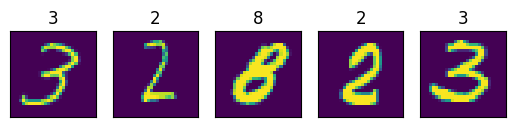

In [12]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch
Simple, fully connected neural network with one hidden layer. Input layer has 784 dimensions (28x28), hidden layer has 98 (= 784 / 8) and output layer 10 neurons, representing digits 0 - 9.

In [13]:
import torch
from torch import nn
import torch.nn.functional as F

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
print(device)

cuda


In [16]:
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

In [17]:
mnist_dim, hidden_dim, output_dim

(784, 98, 10)

A Neural network in PyTorch's framework.

In [18]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

skorch allows to use PyTorch's networks in the SciKit-Learn setting:

In [19]:
from skorch import NeuralNetClassifier

In [20]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=20,
    lr=0.1,
    device=device,
)

In [21]:
net.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8387       0.8800        0.4174  1.5601
      2        0.4332       0.9103        0.3133  0.8785
      3        0.3612       0.9233        0.2684  0.8923
      4        0.3233       0.9309        0.2317  0.8917
      5        0.2938       0.9353        0.2173  0.8810
      6        0.2738       0.9390        0.2039  0.8960
      7        0.2600       0.9454        0.1868  1.3529
      8        0.2427       0.9484        0.1757  1.1685
      9        0.2362       0.9503        0.1683  1.0849
     10        0.2226       0.9512        0.1621  1.1712
     11        0.2184       0.9529        0.1565  0.8763
     12        0.2090       0.9541        0.1508  0.8522
     13        0.2067       0.9570        0.1446  0.8722
     14        0.1978       0.9570        0.1412  0.8739
     15        0.1923       0.9582        0.1392  0.8665
     16        0.1889       0.9

## Prediction

In [22]:
from sklearn.metrics import accuracy_score

In [23]:
y_pred = net.predict(X_test)

In [24]:
accuracy_score(y_test, y_pred)

0.9631428571428572

In [27]:
X_test[0].shape

(784,)

In [34]:
net.module_.forward(torch.tensor(X_test[0], device=device))

tensor([2.8163e-08, 1.2802e-07, 1.7493e-04, 1.5174e-03, 8.6505e-10, 1.8852e-04,
        6.6384e-09, 9.1162e-08, 9.9812e-01, 1.1959e-06], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

An accuracy of about 96% for a network with only one hidden layer is not too bad.

Let's take a look at some predictions that went wrong:

In [45]:
error_mask = y_pred != y_test

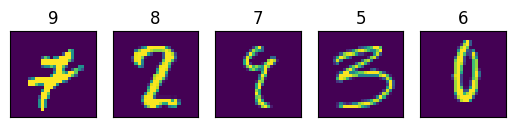

In [46]:
plot_example(X_test[error_mask], y_pred[error_mask])

# Convolutional Network
PyTorch expects a 4 dimensional tensor as input for its 2D convolution layer. The dimensions represent:
* Batch size
* Number of channel
* Height
* Width

As initial batch size the number of examples needs to be provided. MNIST data has only one channel. As stated above, each MNIST vector represents a 28x28 pixel image. Hence, the resulting shape for PyTorch tensor needs to be (x, 1, 28, 28).

In [35]:
XCnn = X.reshape(-1, 1, 28, 28)

In [36]:
XCnn.shape

(70000, 1, 28, 28)

In [37]:
XCnn_train, XCnn_test, y_train, y_test = train_test_split(XCnn, y, test_size=0.25, random_state=42)

In [38]:
XCnn_train.shape, y_train.shape

((52500, 1, 28, 28), (52500,))

In [39]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [40]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [41]:
cnn.fit(XCnn_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4321       0.9717        0.0896  1.9076
      2        0.1651       0.9785        0.0674  1.3967
      3        0.1371       0.9821        0.0571  1.3914
      4        0.1139       0.9850        0.0493  1.6259
      5        0.1027       0.9862        0.0443  1.6154
      6        0.0976       0.9866        0.0411  1.3970
      7        0.0888       0.9862        0.0424  1.3925
      8        0.0868       0.9879        0.0390  1.3914
      9        0.0818       0.9878        0.0390  1.4100
     10        0.0762       0.9887        0.0371  1.4327


In [42]:
y_pred_cnn = cnn.predict(XCnn_test)

In [43]:
accuracy_score(y_test, y_pred_cnn)

0.9882285714285715

An accuracy of >98% should suffice for this example!

Let's see how we fare on the examples that went wrong before:

In [47]:
accuracy_score(y_test[error_mask], y_pred_cnn[error_mask])

0.7674418604651163

Over 70% of the previously misclassified images are now correctly identified.

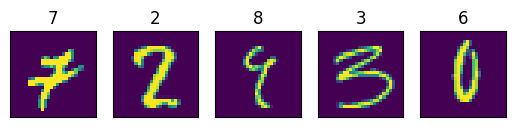

In [48]:
plot_example(X_test[error_mask], y_pred_cnn[error_mask])

In [63]:
# prompt: Write a code snippet that 1. Will use the CNN above to extract features 2. Use such features in a sklearn pipeline to train a logistic regression 3. compute accuracy to see how it compares with the other models

import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Extract features using the trained CNN
cnn_features_train = []
for i in range(0, len(XCnn_train), 100):  # Process in batches to avoid memory issues
    batch = XCnn_train[i:i+100]
    with torch.no_grad():
        features = cnn.module_.forward(torch.tensor(batch, device=device))
        cnn_features_train.extend(features.cpu().numpy())
cnn_features_train = np.array(cnn_features_train)


cnn_features_test = []
for i in range(0, len(XCnn_test), 100):
    batch = XCnn_test[i:i+100]
    with torch.no_grad():
        features = cnn.module_.forward(torch.tensor(batch, device=device))
        cnn_features_test.extend(features.cpu().numpy())
cnn_features_test = np.array(cnn_features_test)

# Create and train a logistic regression model using the extracted features
pipeline = Pipeline([
    ('clf', LogisticRegression(max_iter=1000)) # Increased max_iter for convergence
])

pipeline.fit(cnn_features_train, y_train)

# Predict and evaluate the model
y_pred_lr = pipeline.predict(cnn_features_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression accuracy with CNN features: {accuracy_lr}")


<ipython-input-63-e18358f52827>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = cnn.module_.forward(torch.tensor(batch, device=device))
<ipython-input-63-e18358f52827>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = cnn.module_.forward(torch.tensor(batch, device=device))


Logistic Regression accuracy with CNN features: 0.9885142857142857


In [59]:
# prompt: Repeat what you did above, but instead of the CNN built above, use another famous model like Resnet or Alexnet downloaded from huggingface transformers

import numpy as np
#!pip install transformers

from transformers import ResNetModel
import torch

# Assuming XCnn_train and XCnn_test are defined as in the previous code

# Load pre-trained ResNet model from Hugging Face Transformers
resnet_model = ResNetModel.from_pretrained("microsoft/resnet-50")
resnet_model.to(device) # Move to GPU if available

# Repeat the grayscale image 3 times to create a 3-channel input
XCnn_train_3ch = XCnn_train.repeat(1, 3, 1, 1) # Repeat along the channel dimension
XCnn_test_3ch = XCnn_test.repeat(1, 3, 1, 1)

XCnn_train_3ch = torch.tensor(XCnn_train_3ch, device=device)
XCnn_test_3ch = torch.tensor(XCnn_test_3ch, device=device)

# Extract features using the ResNet model
resnet_features_train = []
for i in range(0, len(XCnn_train_3ch), 100):
    batch = XCnn_train_3ch[i:i+100].to(device)
    with torch.no_grad():
      outputs = resnet_model(batch)
      # Extract features from the average of the last hidden state
      features = outputs.last_hidden_state.mean(dim=[1,2]).cpu().numpy()
      resnet_features_train.extend(features)

resnet_features_train = np.array(resnet_features_train)


resnet_features_test = []
for i in range(0, len(XCnn_test_3ch), 100):
    batch = XCnn_test_3ch[i:i+100].to(device)
    with torch.no_grad():
      outputs = resnet_model(batch)
      # Extract features from the average of the last hidden state
      features = outputs.last_hidden_state.mean(dim=[1,2]).cpu().numpy()
      resnet_features_test.extend(features)

resnet_features_test = np.array(resnet_features_test)

<ipython-input-59-f5a89ccc2789>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  XCnn_train_3ch = torch.tensor(XCnn_train_3ch, device=device)
<ipython-input-59-f5a89ccc2789>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  XCnn_test_3ch = torch.tensor(XCnn_test_3ch, device=device)


In [60]:
resnet_features_train.shape

(52500, 1)

In [64]:
# Reshape the features to 2D before fitting
resnet_features_train_2d = resnet_features_train.reshape(resnet_features_train.shape[0], -1)
resnet_features_test_2d = resnet_features_test.reshape(resnet_features_test.shape[0], -1)

In [65]:
# Create and train a logistic regression model using the extracted features
pipeline = Pipeline([
       ('scaler', StandardScaler()),  # Add StandardScaler for feature scaling
       ('clf', LogisticRegression(max_iter=1000))
   ])

pipeline.fit(resnet_features_train_2d, y_train)


# Predict and evaluate the model
y_pred_lr = pipeline.predict(resnet_features_test_2d)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression accuracy with ResNet features: {accuracy_lr}")

Logistic Regression accuracy with ResNet features: 0.24097142857142856
